In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
#from sklearn.metrics import 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

-----
### Train, valid split

In [2]:
pars_smp_train = np.load('data/pars_smp_train.npy')
y_smp_train = np.load('data/y_smp_train.npy')

In [3]:
pars_smp_train.shape, y_smp_train.shape

((1000000, 15, 1), (1000000, 200, 3))

In [4]:
test_data_size = 1000000
small_pars_smp_train = pars_smp_train[:test_data_size].copy()
small_y_smp_train = y_smp_train[:test_data_size].copy()

In [5]:
if test_data_size != 1000000:
    X_train, X_valid, y_train, y_valid = train_test_split(small_pars_smp_train, small_y_smp_train, test_size=0.2, shuffle=False, random_state=178)
    X_valid = np.array(0)
    y_valid = np.array(0)
else:
   X_train=small_pars_smp_train
   y_train=small_y_smp_train
   X_valid = np.array(0)
   y_valid = np.array(0)

In [6]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1000000, 15, 1), (1000000, 200, 3), (), ())

In [7]:
use_cuda = True
if use_cuda:
    device = 'cuda'
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'

In [8]:
torch.cuda.is_available()

True

In [9]:
class MacroEconomicModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MacroEconomicModel, self).__init__()
        #self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        #self.fc = nn.Linear(hidden_size, output_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        128, 2
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Используйте только последний временной шаг для предсказания
        return out

# Определение размеров входных и выходных данных
input_size = 3  # Размерность данных о приросте ВВП, инфляции и процентной ставке
hidden_size = 128  # Размер скрытого состояния RNN
output_size = 15  # Размер параметров модели
num_layers = 2  # Количество слоев LSTM     
                                
# Создание экземпляра модели
model = MacroEconomicModel(input_size, hidden_size, output_size, num_layers).to(device=device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import tqdm
# Преобразование данных в тензоры PyTorch
y_train = torch.Tensor(y_train)
X_train = torch.Tensor(X_train)

y_valid = torch.Tensor(y_valid)
X_valid = torch.Tensor(X_valid)


batch_size = 200
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_dataset = TensorDataset(y_train, X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

valid_dataset = TensorDataset(y_valid, X_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, **kwargs)

sss = int(X_train.shape[0]/batch_size+1)
# Обучение модели
num_epochs = 10  # Количество эпох обучения
history = {
    'training_loss':[],
    'validation_loss':[]
}
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    batch_losses = []#.to(device)
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Проход вперед (forward pass)
        outputs = model(inputs)

        # Вычисление функции потерь
        loss = torch.sqrt(criterion(outputs, targets.squeeze()))
        #batch_losses.append(loss.detach().numpy())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    #print(len(batch_losses))
    training_loss = np.mean(batch_losses)
    
    # with torch.no_grad():
    #     batch_val_losses = []
    #     for batch_val in valid_loader:
    #         inputs_val, targets_val = batch_val
    #         inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
    #         #print(inputs_val.shape, targets_val.shape)
    #         model.eval()

    #         # Проход вперед (forward pass)
    #         outputs_val = model(inputs_val)

    #         # Вычисление функции потерь
    #         loss_val = torch.sqrt(criterion(outputs_val, targets_val.squeeze()))
    #         batch_val_losses.append(loss_val)
    #         #print(batch_val_losses)
    #        # print(type(batch_val_losses))
    #         validation_loss = torch.mean(torch.stack(batch_val_losses))



    # Выводим информацию о процессе обучения
    #print(f'Эпоха [{epoch + 1}/{num_epochs}], Потери train: {loss.item()}')
    print(f'Эпоха [{epoch + 1}/{num_epochs}]')
    print( f'Потери train: {training_loss.item()}')
    #print(f'Loss valid: {validation_loss.item()}')
    history['training_loss'].append(training_loss.item())
    #history['validation_loss'].append(validation_loss.item())

 10%|█         | 1/10 [02:45<24:47, 165.32s/it]

Эпоха [1/10]
Потери train: 0.23150288766920565


 10%|█         | 1/10 [02:50<25:38, 170.91s/it]


KeyboardInterrupt: 

{'training_loss': [1.0981599688529968, 1.0208296030759811, 0.7606601715087891, 0.4559684693813324, 0.38691606372594833, 0.3565667122602463, 0.3446536138653755, 0.3286153972148895, 0.3308465778827667, 0.3263285756111145], 'validation_loss': []}


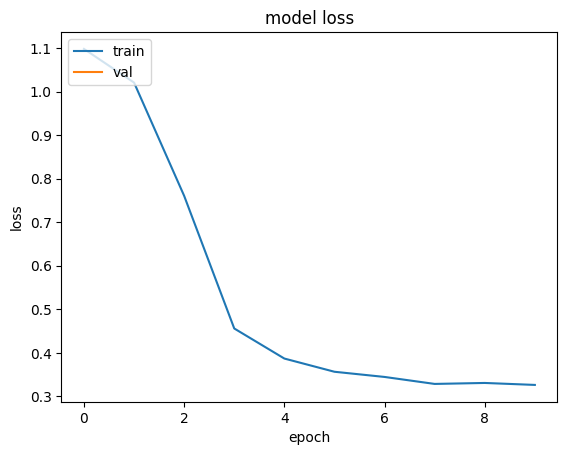

In [ ]:
print(history)
from matplotlib import pyplot as plt
#plt.plot(torch.stack(history['training_loss']).cpu())
plt.plot(history['training_loss'])
plt.plot(history['validation_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'trained_model_target_1000000.pth')

In [ ]:
outputs_val.shape

NameError: name 'outputs_val' is not defined

----
### Prediction

In [ ]:
# y_smp_test = np.load('data/y_smp_test.npy')
# y_test = torch.Tensor(y_smp_test)
# y_test.shape

In [ ]:
# # Create dataloader
# test_dataset = TensorDataset(y_test)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# # Evalute model on test data
# with torch.no_grad():
#     all_outputs_test = []
#     for batch in test_loader:
#         inputs_test = batch[0]
#         inputs_test = inputs_test.to(device=device)
#         model.eval()

#         outputs_test = model(inputs_test).unsqueeze(2)
#         all_outputs_test.append(outputs_test)

#     # Concat to common tensor
#     final_outputs_test = torch.cat(all_outputs_test, dim=0)

In [ ]:
# batch_size = 5  # Window size

# # Empty tensor for saving result
# result = torch.zeros((final_outputs_test.size(0), final_outputs_test.size(1), 6))

# for i in range(0, final_outputs_test.size(0), batch_size):
#     batch = final_outputs_test[i:i+batch_size]
    
#     # Calculate mean
#     batch_mean = torch.mean(batch, dim=0).squeeze(1)

#     # Sort batch for calculate quantiles
#     sorted_batch, _ = torch.sort(batch, dim=0)

#     quantiles = torch.quantile(sorted_batch, torch.Tensor([0.1, 0.25, 0.5, 0.75, 0.9]), dim=0).to(device=device)

#     # Save to final tensor
#     result[i:i+batch_size, :, 0] = batch_mean
#     result[i:i+batch_size, :, 1:6] = quantiles

# result.shape

In [ ]:
batch_size = 5  # Window size

# Empty tensor for saving result
result = torch.zeros((final_outputs_test.size(0), final_outputs_test.size(1), 6))

for i in range(0, final_outputs_test.size(0), batch_size):
    batch = final_outputs_test[i:i+batch_size]
    
    # Calculate mean
    batch_mean = torch.mean(batch, dim=0).squeeze(1)

    # Sort batch for calculate quantiles
    sorted_batch, _ = torch.sort(batch, dim=0)
    sorted_batch = sorted_batch.to(device=device)
    quantiles = torch.quantile(sorted_batch, torch.Tensor([0.1, 0.25, 0.5, 0.75, 0.9]).to(device=device), dim=0)

    # Save to final tensor
    result[i:i+batch_size, :, 0] = batch_mean
    result[i:i+batch_size, :, 1:6] = quantiles

result.shape

NameError: name 'final_outputs_test' is not defined

In [ ]:
np.save(file='submission.npy', arr=result)